In [27]:
from importlib import reload
import qubic.job_manager as jm
import chipcalibration.rabi_experiments as rabi
import chipcalibration.ramsey as gordon
from matplotlib import pyplot as plt
from distproc.hwconfig import FPGAConfig, load_channel_configs
import chipcalibration.config as cfg
import qubic.rpc_client as rc
import numpy as np
import logging
import chipcalibration.graph as graph
import chipcalibration.measurement as ms
import networkx as nx
reload(ms)
import logging
logging.getLogger(__name__).setLevel(logging.INFO)

In [28]:
fpga_config = FPGAConfig(**{'fpga_clk_period': 2.e-9, 'alu_instr_clks': 5, 'jump_cond_clks': 5, 'jump_fproc_clks': 5,
                            'pulse_regwrite_clks': 3})

qchipname = 'X4Y2'
fpga_config, qchip, channel_config = cfg.load_configs(qchipname, qchip_file='qubitcfg.json')

runner = rc.CircuitRunnerClient(ip='192.168.1.247')
job_manager = jm.JobManager(fpga_config, channel_config, runner, qchip)

In [29]:
qubits = ['Q0', 'Q1', 'Q2', 'Q3']
delta_amps_db = np.array([-1, 0])
delta_f = np.linspace(-2.e6, 2.e6, 100)

In [30]:
cal_graph = graph.CalibrationGraph()

In [31]:
for qubit in qubits:
    cal_graph.add_calibration_step('{}_blob'.format(qubit), 
                                   ms.MeasurementCalibration(qubit, delta_amps_db, delta_f, channel_config),
                                   [qubit], shots_per_circuit=1000)
cal_graph.add_calibration_step('gmm_cal', rabi.GMMRabi(qubits, np.linspace(0, 100e-9, 40), 
                                                     channel_configs=channel_config), qubits, 
                            shots_per_circuit=1000, predecessor_nodes=['{}_blob'.format(qubit) for qubit in qubits])

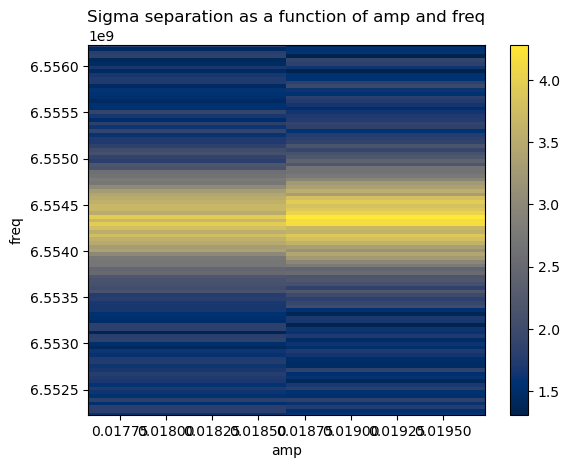

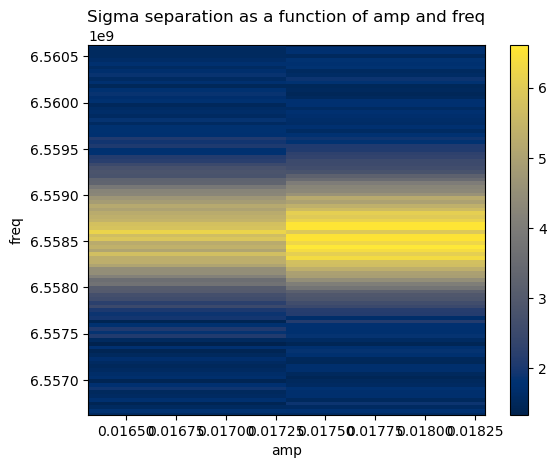

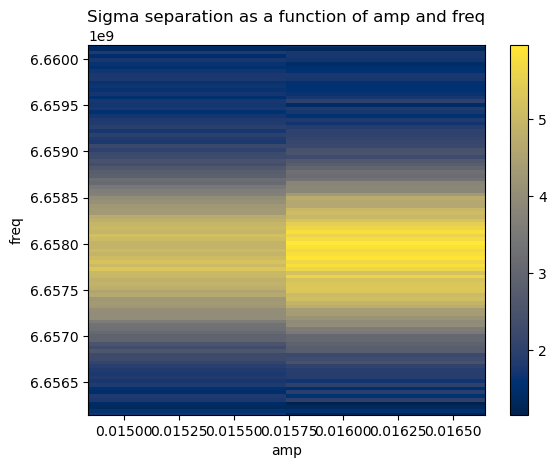

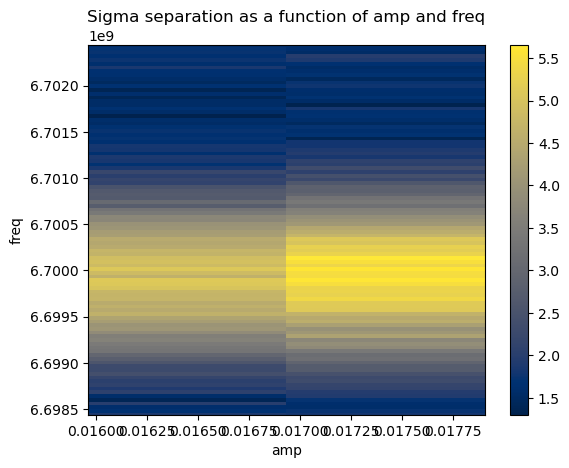

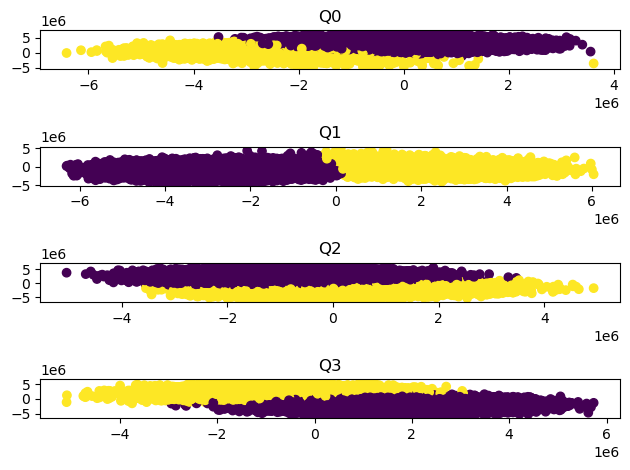

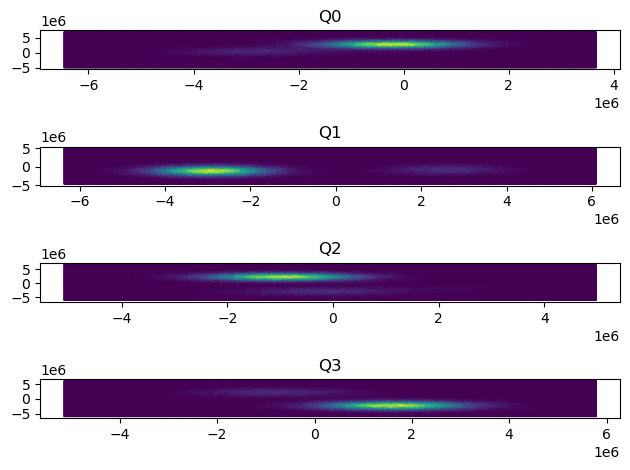

<Figure size 640x480 with 0 Axes>

In [32]:
cal_graph.run_calibration(job_manager, qchip, show_plots=True)

In [33]:
cal_graph.qchip.save('../submodules/qchip/X4Y2/qubitcfg.json')

In [34]:
cal_graph.gmm_manager.save('../submodules/qchip/X4Y2/Q0123_gmm_manager.pkl')